<b><font size = 10>    
    </b>
<b><font size = 10>Complex resitivity inversion using cR2</b>
    
**Not completely implemented in the GUI

<font size = 5>First: Importing necessary python libraries 


In [1]:
import numpy as np
import os
import pandas as pd
from scipy.stats.kde import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from pylab import colorbar
from sklearn.metrics import mean_squared_error as mse
import seaborn as sns
import subprocess
#import scipy.interpolate
import time
import easygui as eg
import sys
from collections import *

<font size = 5> Universal functions:

In [2]:
def res(data): # calculating Resistance (ohm)
    R = data[:,5]/data[:,6]
    return R
def fit(x,a,m): # power-law fit (based on previous studies)
    return a*(x**m)
def fit_lin(x,m,b):
    return m*x+b
def positive_test (Dcurve,DecayTime): #calculating decay curve trend - positive trends are bad data
    DC_slope = np.zeros(np.shape(Dcurve)[0])
    for i in range(np.shape(Dcurve)[0]):     
        DecayCoefs = np.linalg.lstsq(np.vstack([DecayTime, np.ones(len(DecayTime))]).T,Dcurve.iloc[i,:])[0]
        DC_slope[i]=DecayCoefs[0]
    return DC_slope
def R_sqr (y,y_predict): # calculating R squared value to measure fitting accuracy
    	rsdl = y - y_predict
    	ss_res = np.sum(rsdl**2)
    	ss_tot = np.sum((y-np.mean(y))**2)
    	R2 = 1-(ss_res/ss_tot)
    	R2 = np.around(R2,decimals=4)
    	return R2
def linear_coefs (x,y): #linear fit parameteres for decay curve
    data = np.concatenate((np.log(x)[:,None],np.log(y)[:,None]),axis=1)
    if np.log(y).sum() !=0:
        data_no_nan = data[~np.isnan(data).any(axis=1)]
        coefs = np.linalg.lstsq(np.vstack([data_no_nan[:,0], np.ones(len(data_no_nan[:,0]))]).T,data_no_nan[:,1])[0]
        return coefs
    else:
        coefs = np.array([0,0])
        return
    
def heatmap(data,filter_type,name_time): # (Reference: Orozco, A. F., K. H. Williams, and A. Kemna (2013), Time-lapse spectral induced polarization imaging of stimulated uranium bioremediation, Near Surf. Geophys., 11(5), 531–544, doi:10.3997/1873-0604.2013020)
    temp_heatmap_recip_filterN = data[['An','Mn','IPn']].drop_duplicates(subset=['An','Mn'], keep = 'first')
    temp_heatmap_recip_filterN ['Phase'] = temp_heatmap_recip_filterN ['IPn']*1.2
    heat_recip_Filter = temp_heatmap_recip_filterN .set_index(['Mn','An']).IPn.unstack(0)
    fig = plt.figure()
    plt.imshow(heat_recip_Filter, origin='lower',cmap='jet',vmin=0, vmax=25)
    plt.xticks(np.arange(0,temp_heatmap_recip_filterN ['An'].max()+1,4))
    plt.yticks(np.arange(0,temp_heatmap_recip_filterN ['Mn'].max(),4))
    plt.ylabel('A',fontsize=28) # actually An
    plt.xlabel('M',fontsize=28) # actually Mn
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 1.25
    plt.title('%s - %s\n' % (name_time,filter_type), fontsize=28)
    plt.grid(False)
    cbhnf = plt.colorbar()
    cbhnf.ax.set_ylabel(r'-$\phi$ [mRad]', fontsize=28)
    cbhnf.ax.tick_params(labelsize=22)
    plot = fig.add_subplot(111)
    plot.tick_params(axis='both', labelsize=22)
    return

def phase_err (data): #(Reference: Orozco, A. F., A. Kemna, and E. Zimmermann (2012), Data error quantification in spectral induced polarization imaging, Geophysics, 77(3), E227, doi:10.1190/geo2010-0194.1)
    numbins_ip = 16 # I prefer 20 bins
#        temp_filtered = common[np.abs(common['percent_error'])<=int(Arrayinfo[5])]
    data = data.query('IPn>0 & IPn<25 & IPr>=0') # based on my data probably should put it in input
    binsize_ip = int(len(data)/numbins_ip) # roughly each been will hav 61 measurements
    error_input_ip = (pd.concat((np.abs(data['Rn']),((data['IPn']-data['IPr'])*-1.2)),axis=1)).rename(columns = {'Rn':'absRn',0:'Phase_dicrep'}).sort_values(by='absRn').reset_index(drop = True)# Sorting data based on R_avg
    bins_ip = pd.DataFrame(np.zeros((numbins_ip,2))).rename(columns = {0:'R_mean',1:'Phi_dis_STD'})
    for i in range(numbins_ip): # bining 
    	ns=i*binsize_ip
    	ne=ns+binsize_ip-1
    	bins_ip.iloc[i,0] = np.abs(error_input_ip['absRn'].iloc[ns:ne].mean())
    	bins_ip.iloc[i,1] = error_input_ip['Phase_dicrep'].iloc[ns:ne].std()  
    bins_ip = bins_ip.dropna().query('R_mean<3')
    coefs_ip= np.linalg.lstsq(np.vstack([np.ones(len(bins_ip.iloc[:,0])), np.log(bins_ip.iloc[:,0])]).T, np.log(bins_ip.iloc[:,1]))[0] # calculating fitting coefficients (a,m)
    R_error_predict_ip = fit(bins_ip.iloc[:,0],np.exp(coefs_ip[0]),coefs_ip[1]) # error prediction based of fitted model
    fig_ip = plt.figure(figsize=(8,6))
    errmodel_plot_ip = plt.semilogx(bins_ip.iloc[:,0],bins_ip.iloc[:,1],'o',label="error",markersize=15)
    fit_line_ip = plt.plot(bins_ip.iloc[:,0],R_error_predict_ip,'r', label="fit",linewidth=5)
    plt.ylabel(r's($\phi$) [mRad]', fontsize =28)
    plt.xlabel(r'LogR [$\Omega$]', fontsize =28)
    plt.xticks(fontsize = 24)
    plt.yticks(fontsize = 24)
#    plt.title('Phase error model', fontsize =28)
    plt.rcParams["axes.edgecolor"] = "0.15"
    plt.rcParams["axes.linewidth"]  = 2
    leg = plt.legend(loc='best', fontsize =24, frameon=True)
    leg.set_frame_on(True)#.set_edgecolor(0.5)
    leg.get_frame().set_edgecolor("black")
    leg.get_frame().set_linewidth(2)

    R2_ip= R_sqr(np.log(bins_ip.iloc[:,1]),np.log(R_error_predict_ip))
    RMSE_ip = mse(np.log(bins_ip.iloc[:,1]),np.log(R_error_predict_ip))**0.5
    a1 = np.around(np.exp(coefs_ip[0]),decimals=3)
    a2 = np.around(coefs_ip[1], decimals=3)
    a3 = np.around(np.exp(coefs_ip[0]),decimals=1)
    a4 = np.around(coefs_ip[1], decimals=1)
    print ('Error model is: Sp(m) = %s*%s^%s (R^2 = %s) \nor simply Sp(m) = %s*%s^%s' % (a1,'R',a2,R2_ip,a3,'R',a4))
    ax = fig_ip.add_subplot(111)
    plt.title(r'a = %s, b = %s, $R^2 = %s$' % (a1,a2, R2_ip), fontsize =28)
#    ax.text(0.75, 0.5,'a = %s\nb = %s' % (a1,a2), verticalalignment='center', horizontalalignment='center', transform=ax.transAxes,fontsize=10)
    ax.grid(False)

#    plt.text(0.2,0.002,'R_err = %s*%s^%s \n(R^2 = %s)' % (a3,'(R_n/r)',a4,R2),fontsize=10)
    plt.show()
    plt.gcf().clear()
    return(a1,a2)

def DCA(data): #(Reference: Flores Orozco, A., Gallistl, J., Bücker, M., & Williams, K. H. (2017). Decay curve analysis for data error quantification in time-domain induced polarization imaging. Geophysics, 83(2), 1–48. https://doi.org/10.1190/geo2016-0714.1)
    data['DC_slope'] = positive_test(data.iloc[:,6:26].copy(),DecayTime) #decay curve trend - positive trends are bad data
    if fileR != 0:
        mm=58
        nn=78
        if data['IPr'].mean() == 0: 
            print('\nNo reciprocal IP data available (fast reciprocal measurement)')
            filtered_R_IP = data.query('(DC_slope<0)')
        else:
            data['IP_n/r_err'] = data['IPn'] - data['IPr']
            filtered_R_IP = data.query('(DC_slope<0)')
    else:
        filtered_R_IP = data.query('(DC_slope<0)')
        mm=28
        nn=48
    DC_fit_linear = np.zeros([len(filtered_R_IP['IPn']),2])
    for i in range(len(filtered_R_IP['IPn'])): #calculating decay curve fit parameteres - m=at^b (m: chargeability, t: time, a and b: fitting parameters)
        DC_fit_linear[i,:] = linear_coefs(DecayTime,filtered_R_IP.iloc[i,6:26])            
    filtered_R_IP['DC_fit_a'],filtered_R_IP['DC_fit_b']=np.exp(DC_fit_linear[:,1]),DC_fit_linear[:,0]
    filtered_R_IP = filtered_R_IP.dropna(subset=['DC_fit_a','DC_fit_b']).query('(DC_fit_a>0) & (DC_fit_b<0) | (DC_fit_a<0) & (DC_fit_b>0)') #filtering meaningless decay curves 
    filtered_R_IP = filtered_R_IP.dropna(subset=['DC_fit_a','DC_fit_b']) #for test, remove it
    fit_DC = pd.DataFrame(filtered_R_IP['DC_fit_a'][:,None]*DecayTime**filtered_R_IP['DC_fit_b'][:,None]) #building fitted decay curve       
    filtered_R_IP = pd.concat([filtered_R_IP.reset_index(drop=True),fit_DC.reset_index(drop=True)], axis=1) #conatenating fitted decay curve dataframe with measured decaycurve        
    filtered_R_IP['DC_rmsd'] = ((((fit_DC.values-filtered_R_IP.iloc[:,6:26].values)**2).sum(axis=1))/np.shape(fit_DC)[1])**0.5 #calculating decay curve RMSD with fitted curve
####  Bulding master decay curves for each IP window
    filtered_R_IP['weight'] = 1/filtered_R_IP['DC_rmsd']
    temp_DC_master = pd.concat([filtered_R_IP.iloc[:,0:2],(pd.DataFrame(filtered_R_IP.iloc[:,mm:nn].values*filtered_R_IP['weight'][:,None]))],axis=1)
    master_DC = pd.DataFrame((temp_DC_master.groupby(['An','Bn']).sum()).values/(filtered_R_IP.groupby(['An','Bn'])['weight']).sum()[:,None])
    groups_temp = filtered_R_IP.groupby(['An','Bn'],sort=True)
    groups_keys = []
    for key in groups_temp.groups.keys():
        groups_keys.append(key)
    groups_keys = pd.DataFrame(np.reshape(groups_keys, (len(groups_keys),2))).rename(columns = {0:'An', 1:'Bn'})
    groups_keys = pd.concat([groups_keys,pd.DataFrame(np.arange(0,len(groups_keys)))], axis=1).rename(columns = {0:'i'})
    groups_keys_sorted = groups_keys.sort_values(['An','Bn']).reset_index(drop=True)
    master_DC_indexed = pd.concat([master_DC,groups_keys_sorted['i']], axis=1).sort_values(['i']).reset_index(drop=True)
    shift = np.linspace(-10, 10, 20)
    appended_groups = []
    groups_list = [groups_temp.get_group(x) for x in groups_temp.groups]  
    for i in range(len(filtered_R_IP.groupby(['An','Bn']))):
        group = groups_list[i]
        temp_K=np.zeros([len(group)])
        for j in range(len(group)):
            errors = np.array([np.mean((master_DC_indexed.iloc[i,:-1][:,None] - group.iloc[j,6:26][:,None] + m)) for m in shift])
            temp_K[j] = np.polyfit(shift, errors, 2)[2]
        group['K'] = temp_K
        appended_groups.append(group)
        percent_progress = i*100/len(filtered_R_IP.groupby(['An','Bn']))
        print('%s%s -Done' % (int(percent_progress),'%'))
    print('100% -Done - finished!')
    appended_groups = pd.concat(appended_groups)
    K_std = np.std(appended_groups['K'])
    final_data = appended_groups.loc[np.abs(appended_groups['K'])<(2*K_std)]
    return (final_data)

<font size = 5>Importing data. Normal and reciprocal in separate files

In [3]:
fileN = 'day_10_n.txt'
fileR = 'day_10_r.txt'
Arrayinfo = [-8, 0, 24, 1, 40, 10]
measure_size = pd.read_csv(fileN, delimiter = ' ', skiprows=1).shape[1] # to see if decay curve data are present
if measure_size>20: # data with decay curve
    rawN = np.loadtxt(fileN, delimiter = ' ', skiprows=1, usecols = (5,6,7,8,11,13,14))
    decayN = np.loadtxt(fileN, delimiter = ' ', skiprows=1, usecols = (np.arange(15,35)))
    DecayTime = np.arange(int(Arrayinfo[4]),np.shape(decayN)[1]*(int(Arrayinfo[4])+1),int(Arrayinfo[4]))
    rawN[:,0:4] = rawN[:,0:4]+1 # to fix electrode locations (if they start at "0")
# building initial normal DataFrames
    dfN = pd.DataFrame(np.concatenate((rawN[:,0:5],res(rawN)[:,None],decayN),axis =1)).rename(columns = {0:'An',1:'Bn',2:'Mn',3:'Nn',4:'IPn',5:'Rn'})
    if fileR !=0:
        rawR = np.loadtxt(fileR, delimiter = ' ', skiprows=1, usecols = (5,6,7,8,11,13,14))
        decayR = np.loadtxt(fileR, delimiter = ' ', skiprows=1, usecols = (np.arange(15,35)))
        rawR[:,0:4] = rawR[:,0:4]+1
# building initial reciprocal DataFrames
        dfR = pd.DataFrame(np.concatenate((rawR[:,0:5],res(rawR)[:,None],decayR),axis =1)).rename(columns = {0:'Ar',1:'Br',2:'Mr',3:'Nr',4:'IPr',5:'Rr'})
else: # data withOUT decay curve
    rawN = np.loadtxt(fileN, delimiter = ' ', skiprows=1, usecols = (5,6,7,8,11,13,14))
    rawN[:,0:4] = rawN[:,0:4]+1 
    dfN = pd.DataFrame(np.concatenate((rawN[:,0:5],res(rawN)[:,None]),axis =1)).rename(columns = {0:'An',1:'Bn',2:'Mn',3:'Nn',4:'IPn',5:'Rn'})
    if fileR != 0:
        rawR = np.loadtxt(fileR, delimiter = ' ', skiprows=1, usecols = (5,6,7,8,11,13,14))
        rawR[:,0:4] = rawR[:,0:4]+1
        dfR = pd.DataFrame(np.concatenate((rawR[:,0:5],res(rawR)[:,None]),axis =1)).rename(columns = {0:'Ar',1:'Br',2:'Mr',3:'Nr',4:'IPr',5:'Rr'})


F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


<font size = 5> Visualizing the phase error in the raw data:</font>
<br><font color = grey>Reference: Orozco, A. F., K. H. Williams, and A. Kemna (2013), Time-lapse spectral induced polarization imaging of stimulated uranium bioremediation, Near Surf. Geophys., 11(5), 531–544, doi:10.3997/1873-0604.2013020

F:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


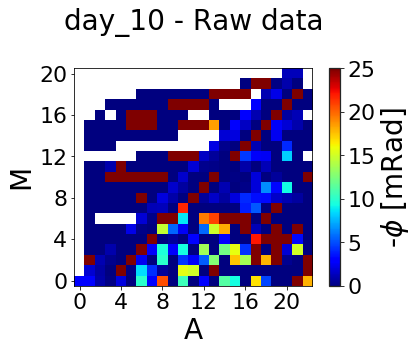

In [4]:
filenames = [fileN, fileR]
dataN = dfN.drop_duplicates(subset=['An', 'Bn', 'Mn', 'Nn'], keep = 'first')
#%% Heatmap of dataN (no filter) (Reference: Orozco, A. F., K. H. Williams, and A. Kemna (2013), Time-lapse spectral induced polarization imaging of stimulated uranium bioremediation, Near Surf. Geophys., 11(5), 531–544, doi:10.3997/1873-0604.2013020)
heatmap(dataN,'Raw data',filenames[0][:-6])
plt.show()

<font size = 5>Reciprocal resistivity error model (power law):</font>
<br><font color = grey>Reference: Robinson, J. L., L. D. Slater, and K. V. R. Schäfer (2012), Evidence for spatial variability in hydraulic redistribution within an oak-pine forest from resistivity imaging, J. Hydrol., 430–431, 69–79, doi:10.1016/j.jhydrol.2012.02.002.

F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
F:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Error model is: R_err = 0.006*(R_n/r)^0.689 (R^2 = 0.9645) 
or simply R_err = 0.0*(R_n/r)^0.7


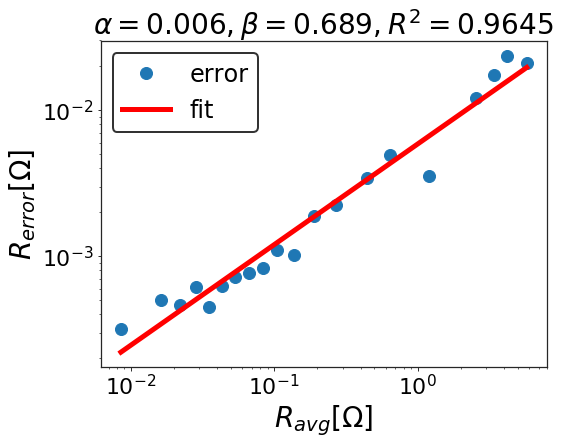

<Figure size 432x288 with 0 Axes>

In [20]:
dataR = dfR.drop_duplicates(subset=['Ar', 'Br', 'Mr', 'Nr'], keep = 'first') # removing duplicates in reciprocal set

#%% Finding common measurements between normal and reciprocal sets
def find_common (N,R):
	df_1 = N
	df_2 = R
	commons_1 = pd.merge(df_1, df_2, how = 'inner', left_on = ['An', 'Bn', 'Mn', 'Nn'], right_on = ['Mr', 'Nr', 'Ar', 'Br'])
	commons_2 = pd.merge(df_1, df_2, how = 'inner', left_on = ['An', 'Bn', 'Mn', 'Nn'], right_on = ['Nr', 'Mr', 'Ar', 'Br'])
	commons_2['Rr'] = commons_2['Rr']*-1
	commons_3 = pd.merge(df_1, df_2, how = 'inner', left_on = ['An', 'Bn', 'Mn', 'Nn'], right_on = ['Mr', 'Nr', 'Br', 'Ar'])
	commons_3['Rr'] = commons_3['Rr']*-1
	commons_4 = pd.merge(df_1, df_2, how = 'inner', left_on = ['An', 'Bn', 'Mn', 'Nn'], right_on = ['Nr', 'Mr', 'Br', 'Ar'])
	commons = pd.concat([commons_1, commons_2, commons_3, commons_4])
	return commons

#%% calculating Resistance errors (between normal and reciprocal dataset) (Reference: Robinson, J. L., L. D. Slater, and K. V. R. Schäfer (2012), Evidence for spatial variability in hydraulic redistribution within an oak-pine forest from resistivity imaging, J. Hydrol., 430–431, 69–79, doi:10.1016/j.jhydrol.2012.02.002.)
common = find_common(dataN,dataR)
common = common.replace([np.inf, -np.inf], np.nan).dropna(subset=['Rn','Rr'])
common['avg_R_n/r'] = common[['Rn','Rr']].mean(axis=1) # average Resistance ((Rn+Rr)/2)
common['|R_err|'] = np.abs(common['Rn']-common['Rr']) # absolute Reciprocal error (|Rn - Rr|) Fi
common['percent_error'] = 100*(common['Rn']-common['Rr'])/common['avg_R_n/r'] # error percentage (100*(Rn - Rr)/R_avg)
common = common.dropna(subset=['percent_error']).drop_duplicates(subset=['An', 'Bn', 'Mn', 'Nn'], keep = 'first')
#%% error analysis (power law)
numbins = 20 # I prefer 20 bins
temp_filtered = common[np.abs(common['percent_error'])<=int(Arrayinfo[5])]
binsize = int(len(temp_filtered)/numbins) 
error_input = np.abs(temp_filtered[['avg_R_n/r','|R_err|']]).sort_values(by='avg_R_n/r') # Sorting data based on R_avg
bins = np.zeros((numbins,2))
for i in range(numbins): # bining 
	ns=i*binsize
	ne=ns+binsize-1
	bins[i,0] = error_input['avg_R_n/r'].iloc[ns:ne].mean()
	bins[i,1] = error_input['|R_err|'].iloc[ns:ne].mean()    
coefs= np.linalg.lstsq(np.vstack([np.ones(len(bins[:,0])), np.log(bins[:,0])]).T, np.log(bins[:,1]))[0] # calculating fitting coefficients (a,m)
R_error_predict = fit(bins[:,0],np.exp(coefs[0]),coefs[1]) # error prediction based of fitted model
fig = plt.figure(figsize=(8,6))
errmodel_plot = plt.loglog(bins[:,0],bins[:,1],'o',label="error", markersize = 12)
fit_line = plt.plot(bins[:,0],R_error_predict,'r', label="fit", linewidth = 5)
plt.ylabel(r'$R_{error} [\Omega]$', fontsize=28)
plt.xlabel(r'$R_{avg} [\Omega]$', fontsize=28)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
#    plt.title('Resistance error model')
#    plt.legend(loc='best',fontsize = 22)
leg = plt.legend(loc='best', fontsize =24, frameon=True)
leg.set_frame_on(True)#.set_edgecolor(0.5)
leg.get_frame().set_edgecolor("black")
leg.get_frame().set_linewidth(2)
R2= R_sqr(np.log(bins[:,1]),np.log(R_error_predict))
RMSE = mse(np.log(bins[:,1]),np.log(R_error_predict))**0.5
a1 = np.around(np.exp(coefs[0]),decimals=3)
a2 = np.around(coefs[1], decimals=3)
a3 = np.around(np.exp(coefs[0]),decimals=1)
a4 = np.around(coefs[1], decimals=1)
print ('Error model is: R_err = %s*%s^%s (R^2 = %s) \nor simply R_err = %s*%s^%s' % (a1,'(R_n/r)',a2,R2,a3,'(R_n/r)',a4))
ax = fig.add_subplot(111)
plt.title(r'$\alpha = %s, \beta = %s, R^2 = %s $' % (a1,a2, R2), fontsize = 28) # error parameters will be ritten on top
# error parameters will be written as in-set equation vvvvvv
#    ax.text(0.75, 0.1,'R_err = %s*%s^%s \n(R^2 = %s)' % (a1,'(R_n/r)',a2,R2), verticalalignment='center', horizontalalignment='center', transform=ax.transAxes,fontsize=18)
ax.tick_params(axis='both', labelsize=22)
ax.grid(False)
#    plt.text(0.2,0.002,'R_err = %s*%s^%s \n(R^2 = %s)' % (a3,'(R_n/r)',a4,R2),fontsize=10)
plt.show()
plt.gcf().clear()

<font size = 5>Reciprocal resistivity error model (linear)

F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()
F:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Error model is: R_err = 0.004*(R_n/r)+0.0007 (R^2 = 0.9454) 
or simply R_err = 0.0*(R_n/r)^0.0


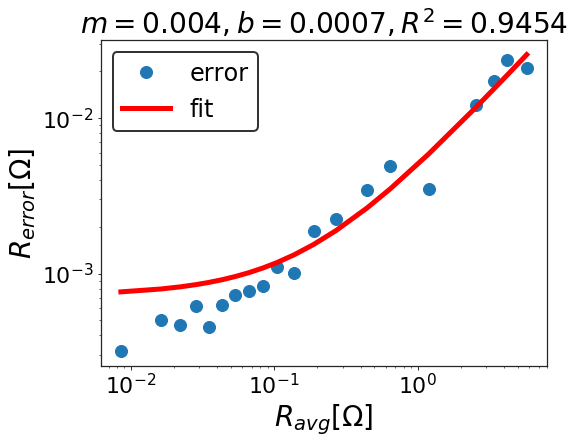

In [6]:
numbins = 20 # I prefer 20 bins
temp_filtered = common[np.abs(common['percent_error'])<=int(Arrayinfo[5])]
binsize = int(len(temp_filtered)/numbins) # roughly each been will hav 61 measurements
error_input = np.abs(temp_filtered[['avg_R_n/r','|R_err|']]).sort_values(by='avg_R_n/r') # Sorting data based on R_avg
bins = np.zeros((numbins,2))
for i in range(numbins): # bining 
	ns=i*binsize
	ne=ns+binsize-1
	bins[i,0] = error_input['avg_R_n/r'].iloc[ns:ne].mean()
	bins[i,1] = error_input['|R_err|'].iloc[ns:ne].mean()    
coefs= np.linalg.lstsq(np.vstack([bins[:,0], np.ones(len(bins[:,0]))]).T, bins[:,1])[0] # calculating fitting coefficients (a,m)
R_error_predict = fit_lin(bins[:,0],coefs[0],coefs[1]) # error prediction based of fitted model
fig = plt.figure(figsize=(8,6))
errmodel_plot = plt.loglog(bins[:,0],bins[:,1],'o',label="error", markersize = 12)
fit_line = plt.loglog(bins[:,0],R_error_predict,'r', label="fit", linewidth = 5)
plt.ylabel(r'$R_{error} [\Omega]$', fontsize=28)
plt.xlabel(r'$R_{avg} [\Omega]$', fontsize=28)
plt.xticks(fontsize = 24)
plt.yticks(fontsize = 24)
leg = plt.legend(loc='best', fontsize =24, frameon=True)
leg.set_frame_on(True)#.set_edgecolor(0.5)
leg.get_frame().set_edgecolor("black")
leg.get_frame().set_linewidth(2)
plt.title('Resistance error model')
#plt.legend(loc='best')
R2= R_sqr(bins[:,1],R_error_predict)
RMSE = mse(bins[:,1],R_error_predict)**0.5
a1 = np.around(coefs[0],decimals=3)
a2 = np.around(coefs[1], decimals=4)
a3 = np.around(coefs[0],decimals=1)
a4 = np.around(coefs[1], decimals=1)
print ('Error model is: R_err = %s*%s+%s (R^2 = %s) \nor simply R_err = %s*%s^%s' % (a1,'(R_n/r)',a2,R2,a3,'(R_n/r)',a4))
#print ('Error model is: R_err = %s*%s^%s (R^2 = %s) \nor simply R_err = %s*%s^%s' % (a1,'(R_n/r)',a2,R2,a3,'(R_n/r)',a4))
ax = fig.add_subplot(111)
plt.title(r'$m = %s, b = %s, R^2 = %s$' % (a1,a2,R2), fontsize = 28) # error parameters will be ritten on top
# error parameters will be written as in-set equation vvvvvv
#    ax.text(0.75, 0.1,'R_err = %s*%s^%s \n(R^2 = %s)' % (a1,'(R_n/r)',a2,R2), verticalalignment='center', horizontalalignment='center', transform=ax.transAxes,fontsize=18)
ax.tick_params(axis='both', labelsize=22)
ax.grid(False)
plt.show()

<font size = 5>Visualizing phase error after reciprocal resitivity filtering (10%)</font>
<br>Still some bad datapoints are present

F:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


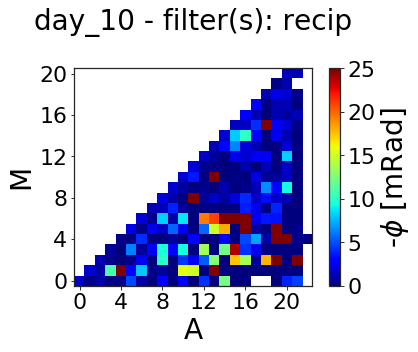

In [8]:
filtered_R_only = common[np.abs(common['percent_error'])<=int(Arrayinfo[5])] 
# Heatmap of reciprocal filtered data
heatmap(filtered_R_only,'filter(s): recip',filenames[0][:-6])

<font size = 5>Calculating phase error model:</font>
<br><font color = grey>Reference: Orozco, A. F., A. Kemna, and E. Zimmermann (2012), Data error quantification in spectral induced polarization imaging, Geophysics, 77(3), E227, doi:10.1190/geo2010-0194.1

F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:65: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
F:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Error model is: Sp(m) = 0.918*R^-0.407 (R^2 = 0.5225) 
or simply Sp(m) = 0.9*R^-0.4


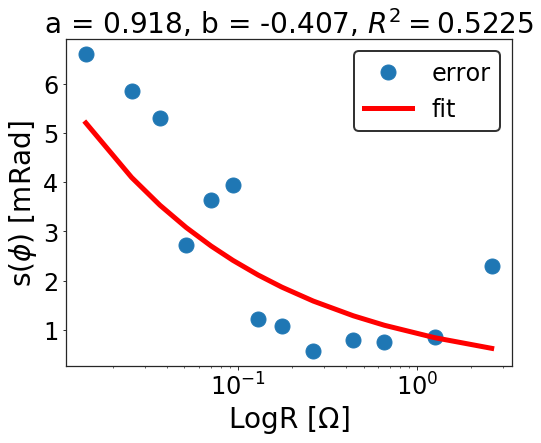

<Figure size 432x288 with 0 Axes>

In [9]:
aip1,aip2=phase_err(filtered_R_only.query('IPn<20.83 & IPn>-20.83'))

<font size = 5>Decay curve analysis:</font>
<br><font color = grey>Reference: Flores Orozco, A., Gallistl, J., Bücker, M., & Williams, K. H. (2017). Decay curve analysis for data error quantification in time-domain induced polarization imaging. Geophysics, 83(2), 1–48. https://doi.org/10.1190/geo2016-0714.1

In [11]:
final_data = DCA(filtered_R_only)
#  Heatmap DCA + reciprocity filtering        

F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  # This is added back by InteractiveShellApp.init_path()
F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in log
F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log
F:\Programs\Anaconda3\lib\


No reciprocal IP data available (fast reciprocal measurement)


F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0% -Done
1% -Done
2% -Done
3% -Done
4% -Done
5% -Done
6% -Done
7% -Done
8% -Done
9% -Done
10% -Done
11% -Done
13% -Done
14% -Done
15% -Done
16% -Done
17% -Done
18% -Done
19% -Done
20% -Done
21% -Done
22% -Done
23% -Done
25% -Done
26% -Done
27% -Done
28% -Done
29% -Done
30% -Done
31% -Done
32% -Done
33% -Done
34% -Done
35% -Done
36% -Done
38% -Done
39% -Done
40% -Done
41% -Done
42% -Done
43% -Done
44% -Done
45% -Done
46% -Done
47% -Done
48% -Done
50% -Done
51% -Done
52% -Done
53% -Done
54% -Done
55% -Done
56% -Done
57% -Done
58% -Done
59% -Done
60% -Done
61% -Done
63% -Done
64% -Done
65% -Done
66% -Done
67% -Done
68% -Done
69% -Done
70% -Done
71% -Done
72% -Done
73% -Done
75% -Done
76% -Done
77% -Done
78% -Done
79% -Done
80% -Done
81% -Done
82% -Done
83% -Done
84% -Done
85% -Done
86% -Done
88% -Done
89% -Done
90% -Done
91% -Done
92% -Done
93% -Done
94% -Done
95% -Done
96% -Done
97% -Done
98% -Done
100% -Done - finished!


F:\Programs\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


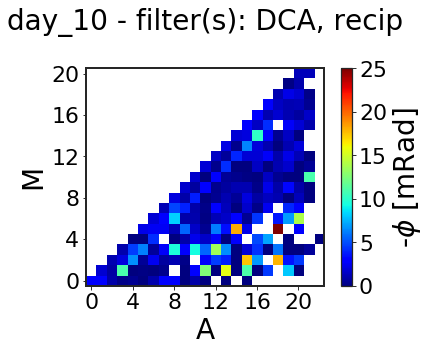

In [12]:
heatmap(final_data,'filter(s): DCA, recip',filenames[0][:-6])

<font size = 5>Building protocol.dat (with individual errors):

In [35]:
protocol = final_data[['Mn','Nn','An','Bn','Rn']]
protocol['Phase'] = final_data['IPn']*-1.2 # (Reference: Mwakanyamale, K., L. Slater, A. Binley, and D. Ntarlagiannis (2012), Lithologic imaging using complex conductivity: Lessons learned from the Hanford 300 Area, GEOPHYSICS, 77(6), E397–E409, doi:10.1190/geo2011-0407.1)
if fileR != 0:
    protocol['|R_err|'] = a1*((np.abs(final_data['Rn'])**a2))
    protocol['Phase_err'] = aip1*(np.abs(protocol['Rn'])**aip2)
protocol = protocol.query('(Phase<0)&(Phase>-25)').reset_index(drop = True) # removing positive and abnormal high phase values 
m = pd.DataFrame(np.arange(len(protocol['Mn']))+1).rename(columns = {0:'Num'})
protocol = pd.concat([m,protocol.reset_index(drop='true')],axis=1)
electrodes = protocol[['Mn','Nn','An','Bn']].astype(int) # integer is needed for R2 or CR2!
#protocolf = pd.concat([protocol[['Num']],electrodes,protocol[['Rn','Phase','|R_err|','Phase_err']]],axis=1)
protocolf = pd.concat([protocol[['Num']],electrodes,protocol.iloc[:,5:]],axis=1)
save_file = open('protocol.dat', 'w')
save_file.write(str(len(protocolf['Num'])) + '\n')
save_file.close()
with open('protocol.dat',mode='a') as file:
    protocolf.to_csv(file,sep='\t',header = None,index=None)

F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

<font size = 5>Building "<i>cR2.in</i>" file (quadrilateral mesh)

In [37]:
h_node_spacing =  5 #Horizontal nods number
v_node_spacing = 0.2 #vertical nodal spacing in meter
array_start = 0 #locations fo first electrode in meters
array_end = (int(Arrayinfo[2])-1)*int(Arrayinfo[3]) #location of last electrode in meters (NumElec-1*spacing)
array = np.arange(array_start, array_end+(int(Arrayinfo[3])/h_node_spacing), int(Arrayinfo[3])/h_node_spacing)  
extend = int(Arrayinfo[3])*2 #Distance to extend the array in meters (twice spacing)
ex_start = np.arange(array_start - extend, array_start, int(Arrayinfo[3])/h_node_spacing)
ex_end = np.arange(array_end + int(Arrayinfo[3])/h_node_spacing, array_end + extend + int(Arrayinfo[3])/h_node_spacing, int(Arrayinfo[3])/h_node_spacing)
fwd = np.append(np.append(ex_start, array), ex_end)

##backwardArea
limit = 2 #backward start limit - log scale
bckw = np.logspace(0.1, limit, 15 )
horizontal =np.sort(np.append(np.append(fwd[0] -bckw, fwd), fwd[-1] + bckw)) #Nodal points in x direction

# Z direction
##ForwardArea
depth_start = 0 #locations of surface
depth_end = np.abs(int(Arrayinfo[0])) #depth of fwd area
darray = np.linspace(depth_start, depth_end, ((depth_end - depth_start)/v_node_spacing +1))  

##backwardArea
total = 90 #total depth
dbckw = np.logspace(np.log10(depth_end), np.log10(total), 15 )
vertical =np.sort(np.append(darray, dbckw[1:]))

elevations = np.zeros(len(horizontal)) #for no elevation data

# Electrode locatios
nodes = pd.DataFrame(np.arange(len(ex_start)+len(bckw)+1,(h_node_spacing)*(int(Arrayinfo[2]))+len(ex_start)+len(bckw)+1,h_node_spacing)) # nodes representing electrodes
elecs = pd.DataFrame(np.arange(1,int(Arrayinfo[2])+1,1))
ones = pd.DataFrame(np.ones_like(nodes))
elements = pd.concat([elecs,nodes,ones],axis=1).astype(int) # last part of cR2.in

# Saving cR2.in
save_cr2in = open('cR2.in', 'w')
with open('cR2.in', mode='a') as file: #saves the output file in right format
    file.write('file\n\n1 4 3.0\n\n%s %s\n\n' % (len(horizontal),len(vertical))) #just any name for 'file and job type is inverse with quadrilateral mesh
    pd.DataFrame(horizontal).T.round(decimals=3).to_csv(file,sep='\t',header = None,index=None)
    file.write(' ' + '\n')
    pd.DataFrame(elevations).T.round(decimals=3).to_csv(file,sep='\t',header = None,index=None)
    file.write(' ' + '\n')
    pd.DataFrame(vertical).T.round(decimals=3).to_csv(file,sep='\t',header = None,index=None)
    file.write('\n\n1\n\n') # num regions
    file.write('1 %s 1 %s 1 -0.1\n\n' % (len(horizontal)-1,len(vertical)-1)) # regions (for simplicity = 1)
    file.write('1 1\n\n') #patch x, patch z
    file.write('1\n\n') #inverse_type
    file.write('1.0 15 1.0 1\n\n') #tolerance, max_iterations, error_mod, alpha_aniso
    if fileR!=0: 
        c_wgt = d_wgt = 0
    else:
        c_wgt = 0.1 # based on your experience
        d_wgt = 1.0
    file.write('0.005 %s %s 2.0 1 10000\n\n' % (c_wgt, d_wgt)) #a_wgt, b_wgt, c_wgt, d_wgt, rho_min, rho_max
    file.write('%s\n' % (Arrayinfo[2])) #number of electrodes
    pd.DataFrame(elements).to_csv(file,sep='\t',header = None, index = None)
    file.write(' ' + '\n')
save_cr2in.close()

F:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


<font size = 5>Calling cR2.exe:

In [ ]:
subprocess.call([r"cR2.exe"])

<font size = 5>Plotting DC resistivity:

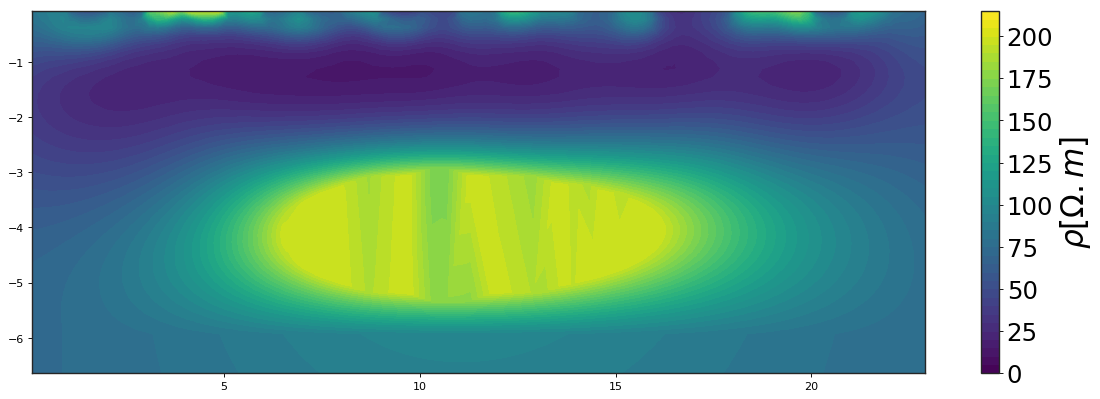

In [13]:
f001 = 'f001.dat'
map_file_R = np.loadtxt(f001,usecols = (0,1,2))
xend = (int(Arrayinfo[2])-1)*int(Arrayinfo[3])
yini = int(Arrayinfo[0])
yend = int(Arrayinfo[1])
map_in_R = pd.DataFrame(map_file_R).rename(columns = {0:'x',1:'y',2:'r'}).query('(x>0)&(x<%s)' % (xend)).reset_index(drop=True)

test  = map_in_R
X = test.values[:,0]
Y = test.values[:,1]
total = test.values
Z = test.values[:,2]
m=1
f=0

for i in Y:
    if Y[f]<yend and Y[f]>yini and Z[f]<200:
        m=m+1
    f=f+1
n,h=[0,0]
T = np.zeros((m,3))

for i in Y:
    if Y[h]<yend and Y[h]>yini and Z[h]<200:
        T[n] = np.copy(total[h])
        n=n+1
    h=h+1
X1 = T[:-1,0]
Y1 = T[:-1,1]
Z1 = T[:-1,2]

x1, y1 = np.meshgrid(X1, Y1)
levels_r = np.arange(0,220,5) # arbitrary values for contouring
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.tricontourf(X1,Y1,Z1,levels_r)
cbrho = plt.colorbar()
cbrho.ax.set_ylabel(r'$\rho [\Omega.m]$', fontsize=28)
cbrho.ax.tick_params(labelsize=22)
plt.show()

<font size = 5>Plotting phase shift (single frequency):</font>
<br><font color = grey>K = -1.2 to convert chargeability values to phase
<br>Reference: Mwakanyamale, K., L. Slater, A. Binley, and D. Ntarlagiannis (2012), Lithologic imaging using complex conductivity: Lessons learned from the Hanford 300 Area, GEOPHYSICS, 77(6), E397–E409, doi:10.1190/geo2011-0407.1

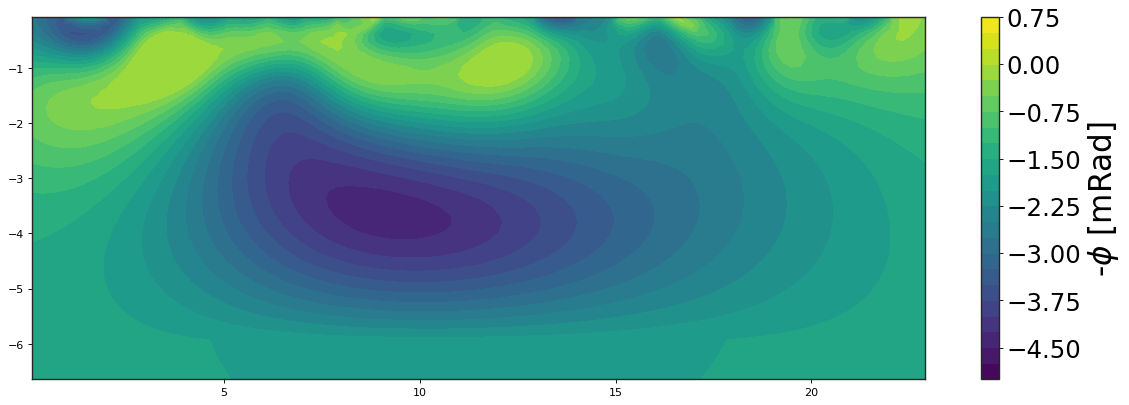

In [19]:
map_file_IP = np.loadtxt('f001.dat',usecols = (0,1,3))
map_in_IP = pd.DataFrame(map_file_IP).rename(columns = {0:'x',1:'y',2:'IP'}).query('(x>0)&(x<%s)' % (xend)).reset_index(drop=True)
IP  = map_in_IP
Xi = IP.values[:,0]
Yi = IP.values[:,1]
totali = IP.values
Zi = IP.values[:,2]
m=1
f=0
for i in Yi:
    if Yi[f]<yend and Yi[f]>yini and Zi[f]<0 and Zi[f]>-18:
        m=m+1
    f=f+1
n,h=[0,0]
Ti = np.zeros((m,3))
for i in Yi:
    if Yi[h]<yend and Yi[h]>yini and Zi[h]<0 and Zi[h]>-18:
        Ti[n] = np.copy(totali[h])
        n=n+1
    h=h+1
X1i = Ti[:-1,0]
Y1i = Ti[:-1,1]
Z1i = Ti[:-1,2]
levels_ip = np.arange(-5,1,0.25) # arbitrary values for contouring
plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.tricontourf(X1i,Y1i,Z1i,levels_ip)
cbip = plt.colorbar()
cbip.ax.set_ylabel(r'-$\phi$ [mRad]', fontsize=28)
cbip.ax.tick_params(labelsize=22)
#plt.set_size_inches(18.5, 10.5)
plt.show()